# Garbage Classification using keras and transfer learning

This kernel shows how to classify Garbage images into 12 different classes using transfer learning. I also created a webapp that can classify garbage images based on the model trained here, fell free to play a bit with it! https://mostafa-portfolio.azurewebsites.net/ .If you find this kernel useful please upvote it!

Transfer learning means that instead of your model learning everything from scratch, it uses another model that was trained on a similar problem, so that you can "transfer" the learned "knowledge" of the pretrained model to your model, and then learn some new features.

The ImageNet Data set is huge data set consisting of more than 14 million images from more than 22,000 different categories, here we are using a smaller version of it which has 1000 different categories.

In this kernel we use an xception model which is pretrained on the ImageNet dataset and then build some layers on top of it to be able to classify the garbage images.

Transfer learning makes sense here because the ImageNet data set has a much larger number of images (14 million) than the Garbage Classification data set (around 15,500 image). This increases the speed of training for our model and the accuracy of our predictions.

# Import Required Libraries

In [6]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# Define Constants

In [13]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


# Create DataFrame

We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category. 
We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list

In [14]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [15]:
df.head()

,filename,category
0,paper/paper574.jpg,0
1,shoes/shoes1348.jpg,6
2,plastic/plastic702.jpg,2
3,clothes/clothes1905.jpg,7
4,battery/battery848.jpg,5


metal/metal628.jpg


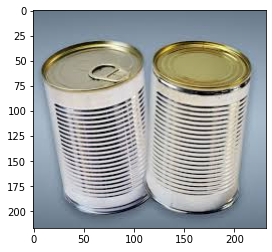

In [16]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

# Viusalize the Categories Distribution

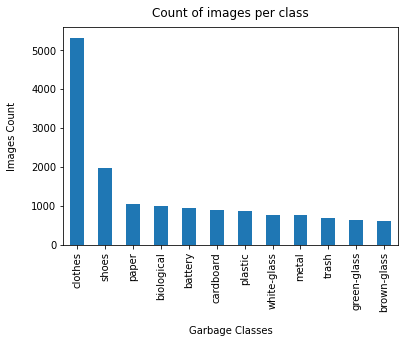

In [17]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Create the model

The steps are:
1. Create an xception model without the last layer and load the ImageNet pretrained weights
2. Add a pre-processing layer
3. Add a pooling layer followed by a softmax layer at the end

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 320, 320, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                24588     
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
_________________________________________________________________


We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [27]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


# Split the Data Set

We split the training set into three separate sets:

1. **The training set:** used to train our model.
1. **The validation set**: used to double check that our model is not overfitting the training set, i.e. it can also generalise to other data other than the train data
1. **The Test set:** Used to estimate the accuracy of the model on new data other than the ones the model used for training
For a competition  or for some other cases, you can split the data only to training and validation sets in order to achieve the highest  possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set

In [28]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


# Train the model

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set.

Applying Data Augmentation on the training set was taking too long to be executed and the initial results didn't show much improvement than the results without augmentation, so I commented the augmentation to make the training faster. However fell free to uncomment the Data Augmentation lines in the following cell and play a bit with it.

In [29]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [30]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
111/193 [================>.............] - ETA: 16:55 - loss: 0.8389 - categorical_accuracy: 0.7775

In [ ]:
model.save_weights("model.h5")

# Visualize the training process


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Evaluate the test

To evaluate the performance of our model we will create a test generator to load the images from the input data directory and evaluate the results.

In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

Great, the accuracy is well over 90% !! (it varies from one run to another due to the random shuffling but is between 94% and 96%) 

But let's have a look on the F1 score for each of the categories. For that we will be using the classification_report from the sklearn package.

In [ ]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

In [ ]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

The table above shows among other info the F1 score of each category. In the bottom of the F1 score column notice two numbers accuracy and macro avg. Accuracy is the same accuracy that we evaluated above for the test set, it is a weighted average. 

However the macro avg (unweighted average) is a bit less than accuracy. This is because the clothes category, the category which has by far the largest number of images, has a very high F1 score, so accuracy (the weighted average) is higher than the unweighted average (macro avg).

For this problem I would consider the macro avg a better measure of accuracy as it takes an average of all the F1 scores regardless of how much data we have in the training data for each category.

## End Note

If you liked this kernel please upvote! I also created a small web app to classify the garbage images, https://mostafa-portfolio.azurewebsites.net/ feel free to play around with it!